<a href="https://colab.research.google.com/github/g7an/artificial_intelligence/blob/main/Copy_of_cifar_10_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1> Neural Networks for Image Classification </h1> </center>

In this homework, we will train a convolutional neural network on a Cifar-10 dataset.

More specifically, we will:
1. Implement an image classification model based on CNN.
2. Train it on Cifar-10 dataset.
3. Apply different optimizers, learning rate scheduling and try different architectures.
4. Add random augmentations to our dataset.
5. Allow you to participate in inclass kaggle competition so that you can compete by trying to find the best model and its training hyperparameters like learning rate, batch size and architecture.

#### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people. In this homework, we will ask you to copy current colaboraty,
complete all the tasks and share your colaboratory notebook with us so
that we can grade it.

#### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write/change/uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected.
5. Paste the link into your submission pdf file so that we can view it and grade.

#### GPU Usage

Before you start working on this homework do the following steps:

1. Press __Runtime > Change Runtime...__ tab. This will allow you to choose if you want to use GPU or TPU or just CPU only.
2. For this assignment select GPU. We will need it for our network to train faster.

#### Kaggle Competition Registration and Submission

1. Follow this link and create account on kaggle and register for the compeition:
https://www.kaggle.com/t/c6b78091b6b8421d97b98ef8f6ab7c57
2. During training of your network a ```csv``` file with your predictions on the test set is being saved. You can find it and download it if you press on the folder icon on the left of your page.
3. Once your model is fully trained and you are satisfied with your results on the validation dataset, download this file and upload your submission to kaggle and it will evaluate your results on the test set. Your submission will be ranked amond all classmates.


<center> <h2> Problem statement </h2> </center>

In this homework we will train convolutional neural network image dataset of with ten classes. We will follow the best practices of training and split our dataset into three parts: training set, validation set and test set. We will experiment with the neural network architecture, training parameters like learning rate, learning rate scheduling, batch size, image augmentations, number of epochs of training.

<center> <h2> Cifar-10 dataset </h2> </center>

For our experiments we will use a subset of [Cifar-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which contains images of ten diverse classes of objects.



![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png "Logo Title Text 1")

<center> <h2> Additional learning resources </h2> </center>

To get a better understanding of Pytorch and to try even simpler neural network architectures on cifar-10 go through these resources. Ideally you should have a basic understanding of tensors, how optimization is performed, loss functions and how to create a model in pytorch.

1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
2. https://colab.research.google.com/drive/1aRhjKyRfuH4C9K1GbTTrM1cswQ0zICbI?usp=sharing

In [ ]:
# Run this to install a dependency
!pip install livelossplot==0.3.4
# !pip install pretrainedmodels
!pip install git+https://github.com/rwightman/pytorch-image-models.git
!pip install torchsummary
!nvidia-smi


  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-4y6radvc
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-4y6radvc
  Created wheel for timm: filename=timm-0.5.0-py3-none-any.whl size=425096 sha256=d33d54f782f9a3dbae93b1cf6b79d1e9c2c765c44f89eed7053df6b085df89c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-obmwgd7y/wheels/a0/ec/5f/289118b747739bb1e02e36cf3d7e759721e881c183653719dc
Successfully built timm
Fri Dec  3 20:01:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |       

In [ ]:
import torch

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import Subset

import torch.nn as nn
import torch.nn.functional as F

import os

from google.colab import drive
import timm

drive.mount('/content/drive')
path = '/content/drive/My Drive/JHU_AI'
print(os.listdir(path))
# os.makedirs(f'{path}/test_mkdir')

# Our simple convolutional neural network which can allow you to get a
# decent accuracy. It consists of a convolutional layers, pooling layer
# and fully connected layer (nn.Linear).
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# Here we define transformation that we will apply to our images
# during training. So far we have a random crop, horizontal flip and normalization.
# Normalization is not an augmentation but a common practice when working with images,
# we are subtracting the average RGB pixel value from each pixel of image and dividing by
# the standart deviation of RGB value in the dataset.
transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomResizedCrop(112, (0.8, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomAutocontrast(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Batch size can be set here.
# trainloader = torch.utils.data.DataLoader(trainset,
#                                           batch_size=256,
#                                           shuffle=True,
#                                           num_workers=4,
#                                           drop_last=True)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

test_and_val_set = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

# Splitting our dataset into valset and test set.
# Valset will be used to monitor our accuracy during training and test set
# will be used to submit your final results to kaggle. It is common for machine
# learning to split dataset into train/val/test and is considered a best practice.
indices = np.arange(len(test_and_val_set))
val_set = Subset(test_and_val_set, indices[:5000])
test_set = Subset(test_and_val_set, indices[5000:])

val_set_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

# Here we define our loss function which is cross entropy -- a common loss function when
# working with classification problems.
criterion = nn.CrossEntropyLoss().cuda()

# Here we are defining our network, putting it on GPU and set it up into a training mode.
# Training mode is needed when some special layers are used like Batch normalization or dropout,
# since they have different behaviour during training and evaluation of our network.
# net = CNN()
# net = pretrainedmodels.__dict__['pnasnet5large'](num_classes=10, pretrained=False)
# net = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=10, pretrained=None)
# net = pretrainedmodels.__dict__['se_resnet50'](num_classes=10, pretrained=None)
# net = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=10, pretrained=None)
# net = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
# print()
# net = timm.create_model('resnet34', pretrained=False, num_classes=10)
net = timm.create_model('efficientnetv2_rw_t', pretrained=False, num_classes=10)

net = net.cuda()
net.train()

# Here we define our optimizer and learning rate. Other optimizers can be used like Adam
# and you can experiment with them -- although you will have to carefully choose learning rate
# in that case.
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Below we define a validation function which will be run after each epoch to
# see if accuracy of our model improved or worsened.
def validate():
    
    net.eval()
    
    counter = 0
    correctly_predicted_counter = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(val_set_loader):

            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = net(inputs)
            _, predicted_classes = outputs.max(1)

            counter += targets.size(0)
            correctly_predicted_counter += (predicted_classes == targets).sum().item()
    
    accuracy = float(correctly_predicted_counter) / counter
    
    predicted_classes_list = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_set_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            _, predicted_classes = outputs.max(1)
            predicted_classes_list += list(map(lambda x: str(x), predicted_classes.cpu().detach().numpy().tolist()))

    predicted_classes_list = list(enumerate(predicted_classes_list))
    
    net.train()
    
    return accuracy, predicted_classes_list

Mounted at /content/drive
[]


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [ ]:
# If you just put a variable containing your model in a cell and run it
# it will output your network structure. Useful for debugging.
# net
from torchsummary import summary
# net = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=10, pretrained=None)
# net = net.cuda()
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 16, 16]             648
       BatchNorm2d-2           [-1, 24, 16, 16]              48
              SiLU-3           [-1, 24, 16, 16]               0
            Conv2d-4           [-1, 24, 16, 16]           5,184
       BatchNorm2d-5           [-1, 24, 16, 16]              48
              SiLU-6           [-1, 24, 16, 16]               0
         ConvBnAct-7           [-1, 24, 16, 16]               0
            Conv2d-8           [-1, 24, 16, 16]           5,184
       BatchNorm2d-9           [-1, 24, 16, 16]              48
             SiLU-10           [-1, 24, 16, 16]               0
        ConvBnAct-11           [-1, 24, 16, 16]               0
           Conv2d-12             [-1, 96, 8, 8]          20,736
      BatchNorm2d-13             [-1, 96, 8, 8]             192
             SiLU-14             [-1, 9

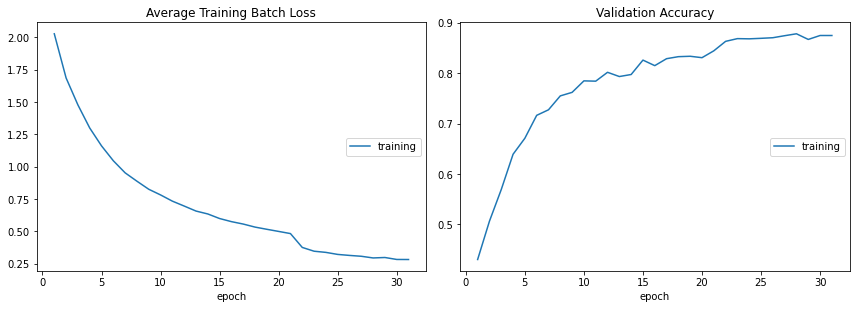

Average Training Batch Loss:
training   (min:    0.281, max:    2.026, cur:    0.281)

Validation Accuracy:
training   (min:    0.430, max:    0.878, cur:    0.875)
41384.12176012993


In [ ]:
%matplotlib inline

from livelossplot import PlotLosses

liveloss = PlotLosses()

import time
import pandas as pd

best_accuracy = 0.0

start = time.time()


for epoch_number in range(31):
    
    train_loss_list = []
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # print(batch_idx, len(trainloader))
        print_gap = 100
        if batch_idx % print_gap == 0:
            if batch_idx != 0:
                curtime = time.time()
                print(f'Remaining time for epoch {epoch_number} is {(curtime - start10)*(6250-batch_idx)/print_gap}s, total time left is {((curtime - start10)*(6250-batch_idx)/print_gap + (curtime - start10)*(100-epoch_number)*(6250/print_gap))/60}m')
            start10 = time.time()
            
                
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.data.item())
    
    if epoch_number == 20:

        for param_group in optimizer.param_groups:

            param_group['lr'] = 0.003

    if epoch_number == 40:

        for param_group in optimizer.param_groups:

            param_group['lr'] = 0.001
        
        
        
    current_accuracy, predicted_classes_list = validate()

    liveloss.update({'Average Training Batch Loss': sum(train_loss_list) / len(train_loss_list),
                     'Validation Accuracy': current_accuracy})
    liveloss.draw()

    if current_accuracy > best_accuracy:

        print(current_accuracy)
        best_accuracy = current_accuracy
        torch.save(net.state_dict(), 'efficient_v2_s_cifar10_kaggle.pth')
        # Saving best predictions so far
        submission_df = pd.DataFrame(predicted_classes_list, columns = ['Id', 'Category'])
        submission_df = submission_df['Category']
        submission_df = submission_df.replace(0)
        submission_df = pd.DataFrame(submission_df)
        submission_df['Id'] = submission_df.index
        submission_df = submission_df[['Id', 'Category']]
        submission_df.to_csv('cifar_10_best_submission.csv', index=False)
        submission_df.to_csv(f'{path}/cifar_10_best_submission_at_{current_accuracy}_epoch_{epoch_number}.csv', index=False)
        
        
end = time.time()
print(end - start)

# Below you can observe drop in the training loss at some point and increase in the validation accuracy.
# This is the place where we decreased the learning rate.

In [ ]:
best_accuracy

0.878

#### Kaggle Competition

To submit your results to Kaggle:

1. Create a kaggle account.
2. Follow the  [link](https://www.kaggle.com/t/c6b78091b6b8421d97b98ef8f6ab7c57) to join the competion.
3. After your code completes, press on the "files" button and download ```cifar_10_best_submission.csv``` file and upload it to kaggle to evaluate it on the test dataset.


#### Additional experiments

To improve your model further try to:

1. Increase the number of filters.
2. Increate the number of layers.
3. Choose different architecture, for example a deep residual network:
https://arxiv.org/pdf/1512.03385.pdf
4. Top three submissions will present their solutions to the class and will potentially get bonus points.